In [1]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
from IPython.display import display, Image
from sklearn.metrics import classification_report, confusion_matrix

In [2]:

class SapotaDataGenerator(Sequence):
    def __init__(self, dataset_path, batch_size, target_size, subset='training'):
        self.dataset_path = dataset_path
        self.batch_size = batch_size
        self.target_size = target_size
        self.subset = subset
        self.datagen = ImageDataGenerator(rescale=1./255)
        self.image_paths, self.class_labels, self.days = self._get_image_paths_and_labels()
        self.indexes = np.arange(len(self.image_paths))
        if subset == 'training':
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_paths = self.image_paths[start:end]
        
        batch_images = np.zeros((len(batch_paths), *self.target_size, 3), dtype=np.float32)
        batch_labels = np.zeros((len(batch_paths),), dtype=np.float32)

        for i, path in enumerate(batch_paths):
            try:
                img = load_img(path, target_size=self.target_size)
                img = img_to_array(img) / 255.0
                
                batch_images[i] = img
                batch_labels[i] = self.class_labels[start + i]
            except Exception as e:
                print(f"Error loading image {path}: {e}")
                batch_images[i] = np.zeros((*self.target_size, 3))
    
        return batch_images, batch_labels
    
    def on_epoch_end(self):
        if self.subset == 'training':
            np.random.shuffle(self.indexes)
    
    def _get_image_paths_and_labels(self):
        image_paths = []
        class_labels = []
        days = []
        
        for day_dir in sorted(os.listdir(self.dataset_path)):
            day_path = os.path.join(self.dataset_path, day_dir)
            if not os.path.isdir(day_path):
                continue
            for condition in ['Rotten', 'Not Rotten']:
                condition_path = os.path.join(day_path, condition)
                if not os.path.exists(condition_path):
                    print(f"Skipping missing directory: {condition_path}")
                    continue
                for image_name in os.listdir(condition_path):
                    image_path = os.path.join(condition_path, image_name)
                    image_paths.append(image_path)
                    class_labels.append(0 if condition == 'Not Rotten' else 1)
                    days.append(int(day_dir))
    
        return image_paths, class_labels, days
    
    def get_class_labels(self):
        return np.array(self.class_labels)[self.indexes]
    
    def analyze_class_distribution(self):
        class_counts = {'Not Rotten': 0, 'Rotten': 0}
        for label in self.class_labels:
            class_name = 'Not Rotten' if label == 0 else 'Rotten'
            class_counts[class_name] += 1
        return class_counts
    
    def analyze_days_distribution(self):
        days_counter = Counter(self.days)
        return days_counter
    
    def balance_dataset(self):
        for day_dir in os.listdir(self.dataset_path):
            day_path = os.path.join(self.dataset_path, day_dir)
            if not os.path.isdir(day_path):
                continue
            class_counts = self.analyze_class_distribution()
            minority_cls = min(class_counts, key=class_counts.get)
            majority_cls = max(class_counts, key=class_counts.get)
            minority_cls_path = os.path.join(day_path, minority_cls)
            minority_count = class_counts[minority_cls]
            augmentation_factor = (class_counts[majority_cls] - minority_count) // minority_count if minority_count > 0 else 0
            if augmentation_factor > 0:
                self._augment_class_images(minority_cls_path, augmentation_factor)
    
    def _augment_class_images(self, class_path, augmentation_factor):
        datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.2
        )

        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=class_path, save_prefix='aug', save_format='jpeg'):
                i += 1
                if i >= augmentation_factor:
                    break


In [3]:
dataset_path = r'dataset' 
batch_size = 32
target_size = (224, 224) 

train_generator = SapotaDataGenerator(dataset_path=dataset_path, batch_size=batch_size, target_size=target_size, subset='training')
validation_generator = SapotaDataGenerator(dataset_path=dataset_path, batch_size=batch_size, target_size=target_size, subset='validation')


First 5 Entries:
Image Path: dataset\2\Rotten\IR_00336.jpg, Class Label: Rotten, Day: 2


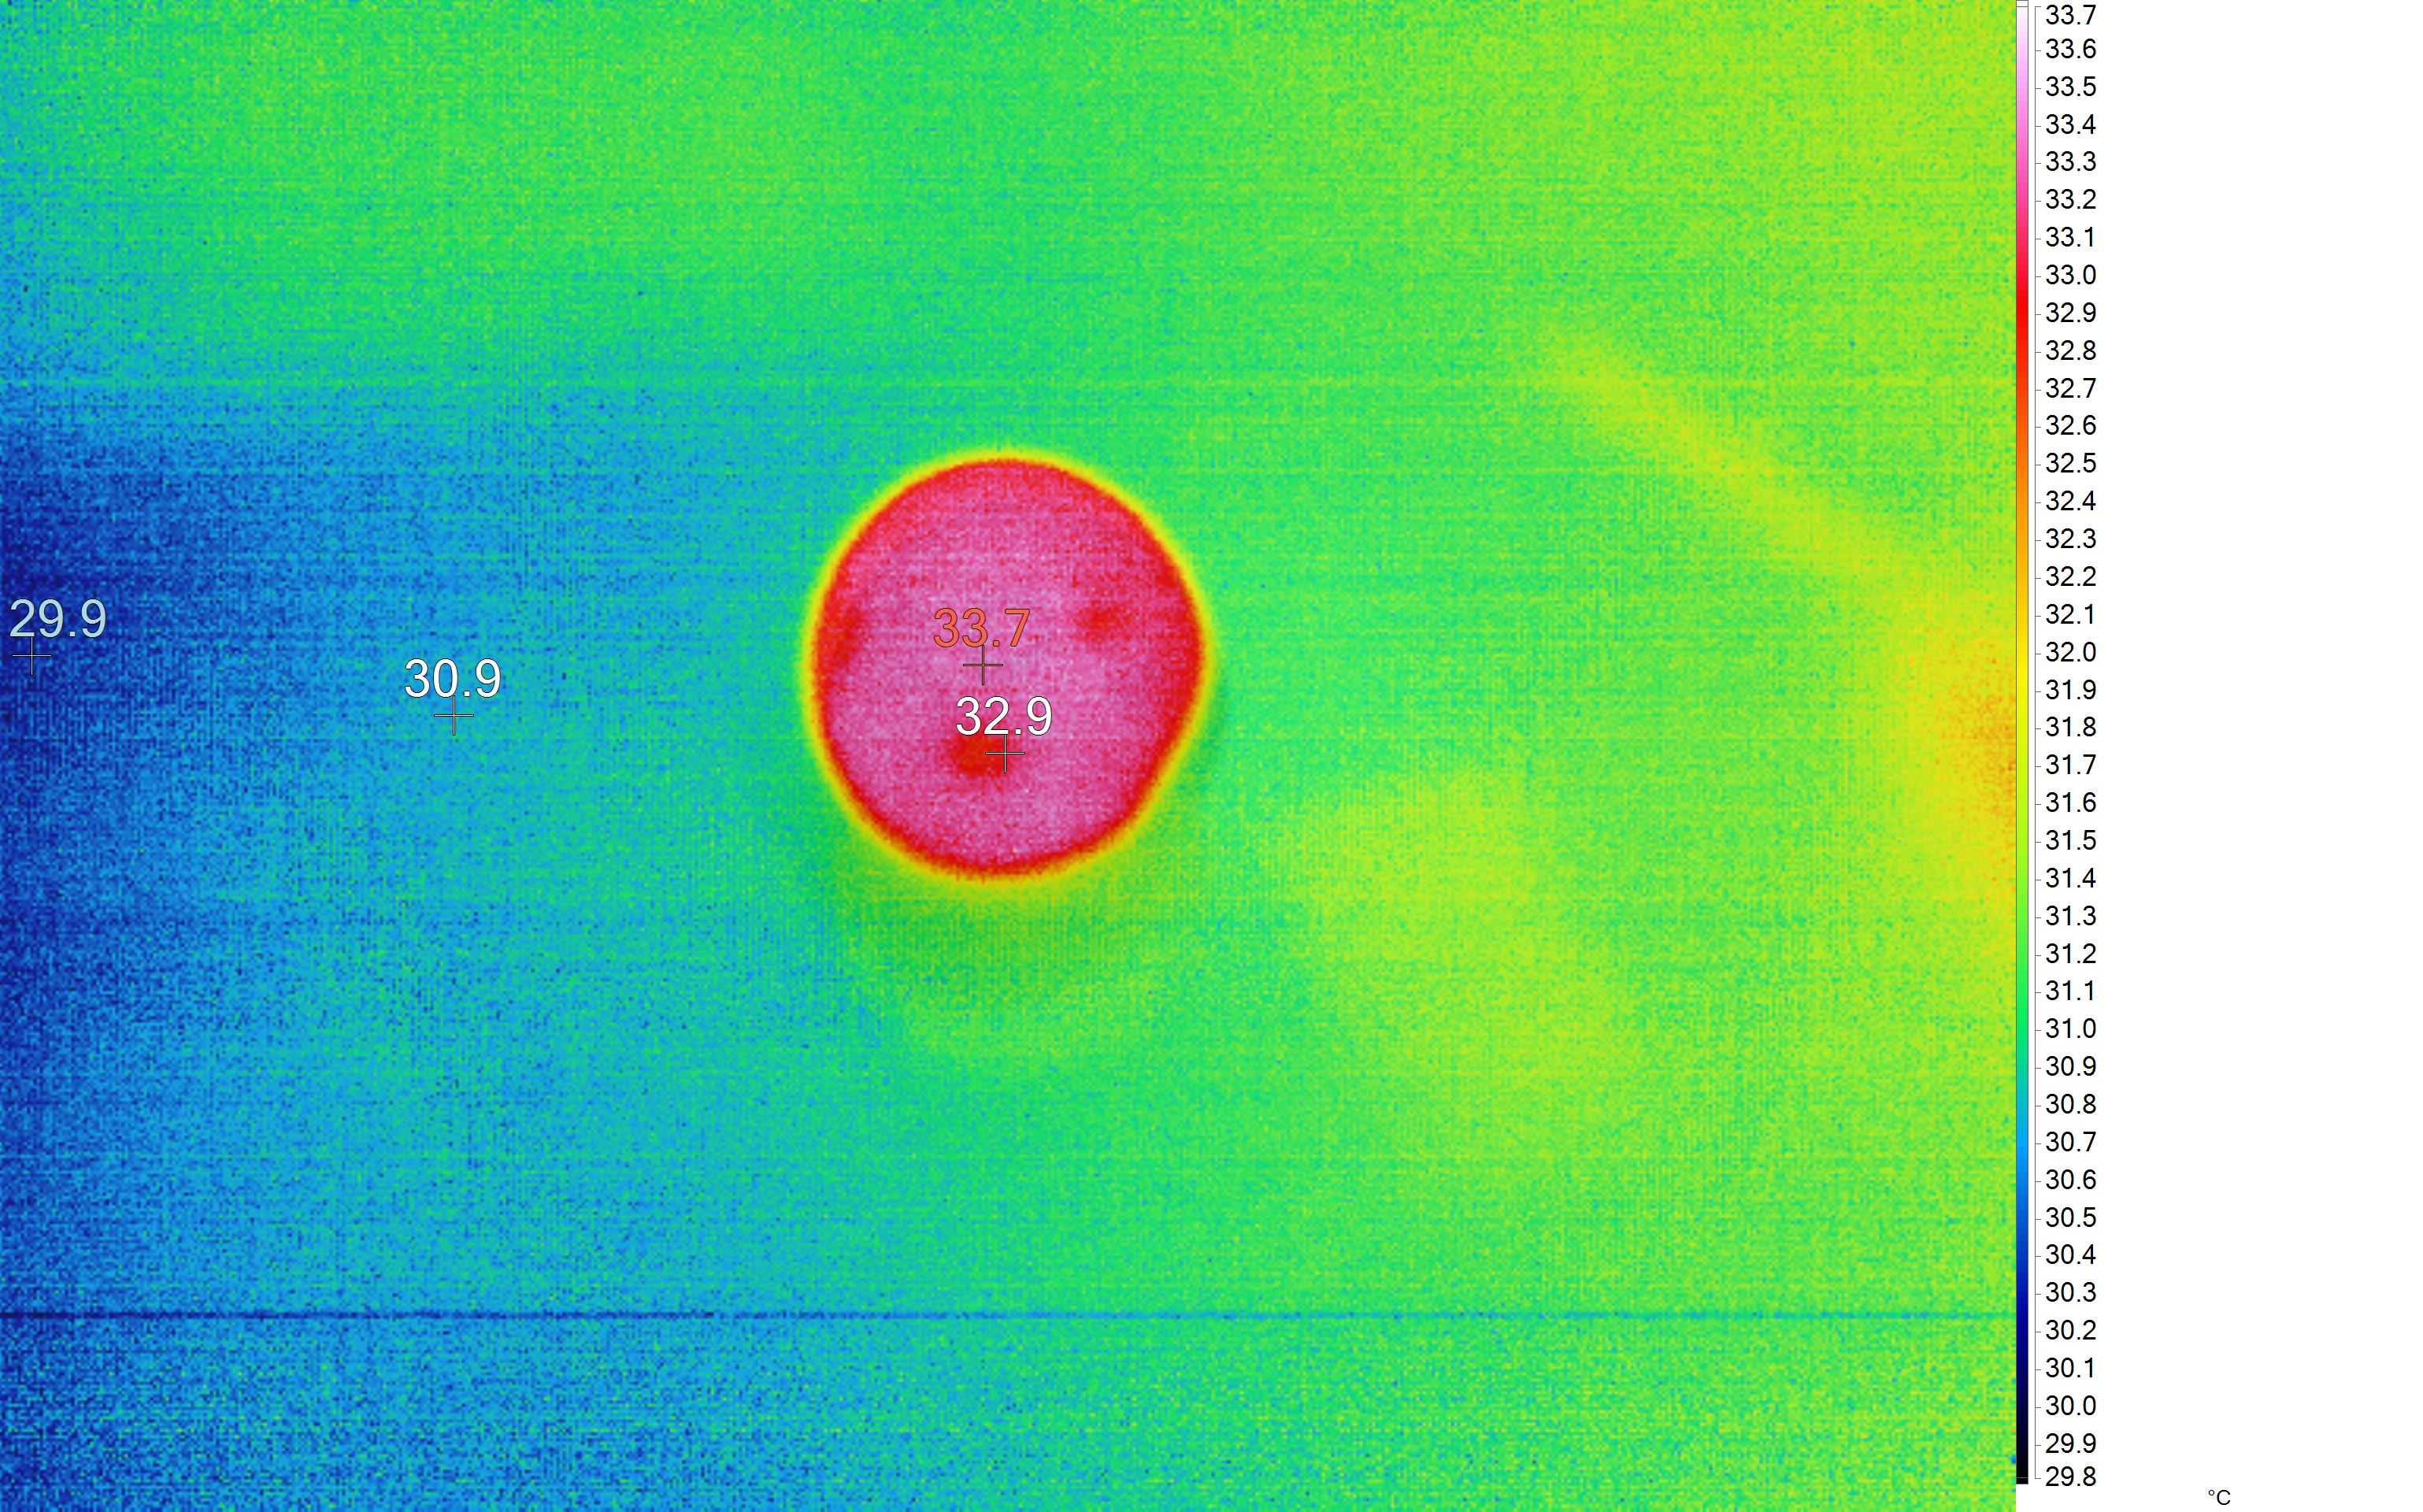

Image Path: dataset\2\Rotten\IR_00337.jpg, Class Label: Rotten, Day: 2


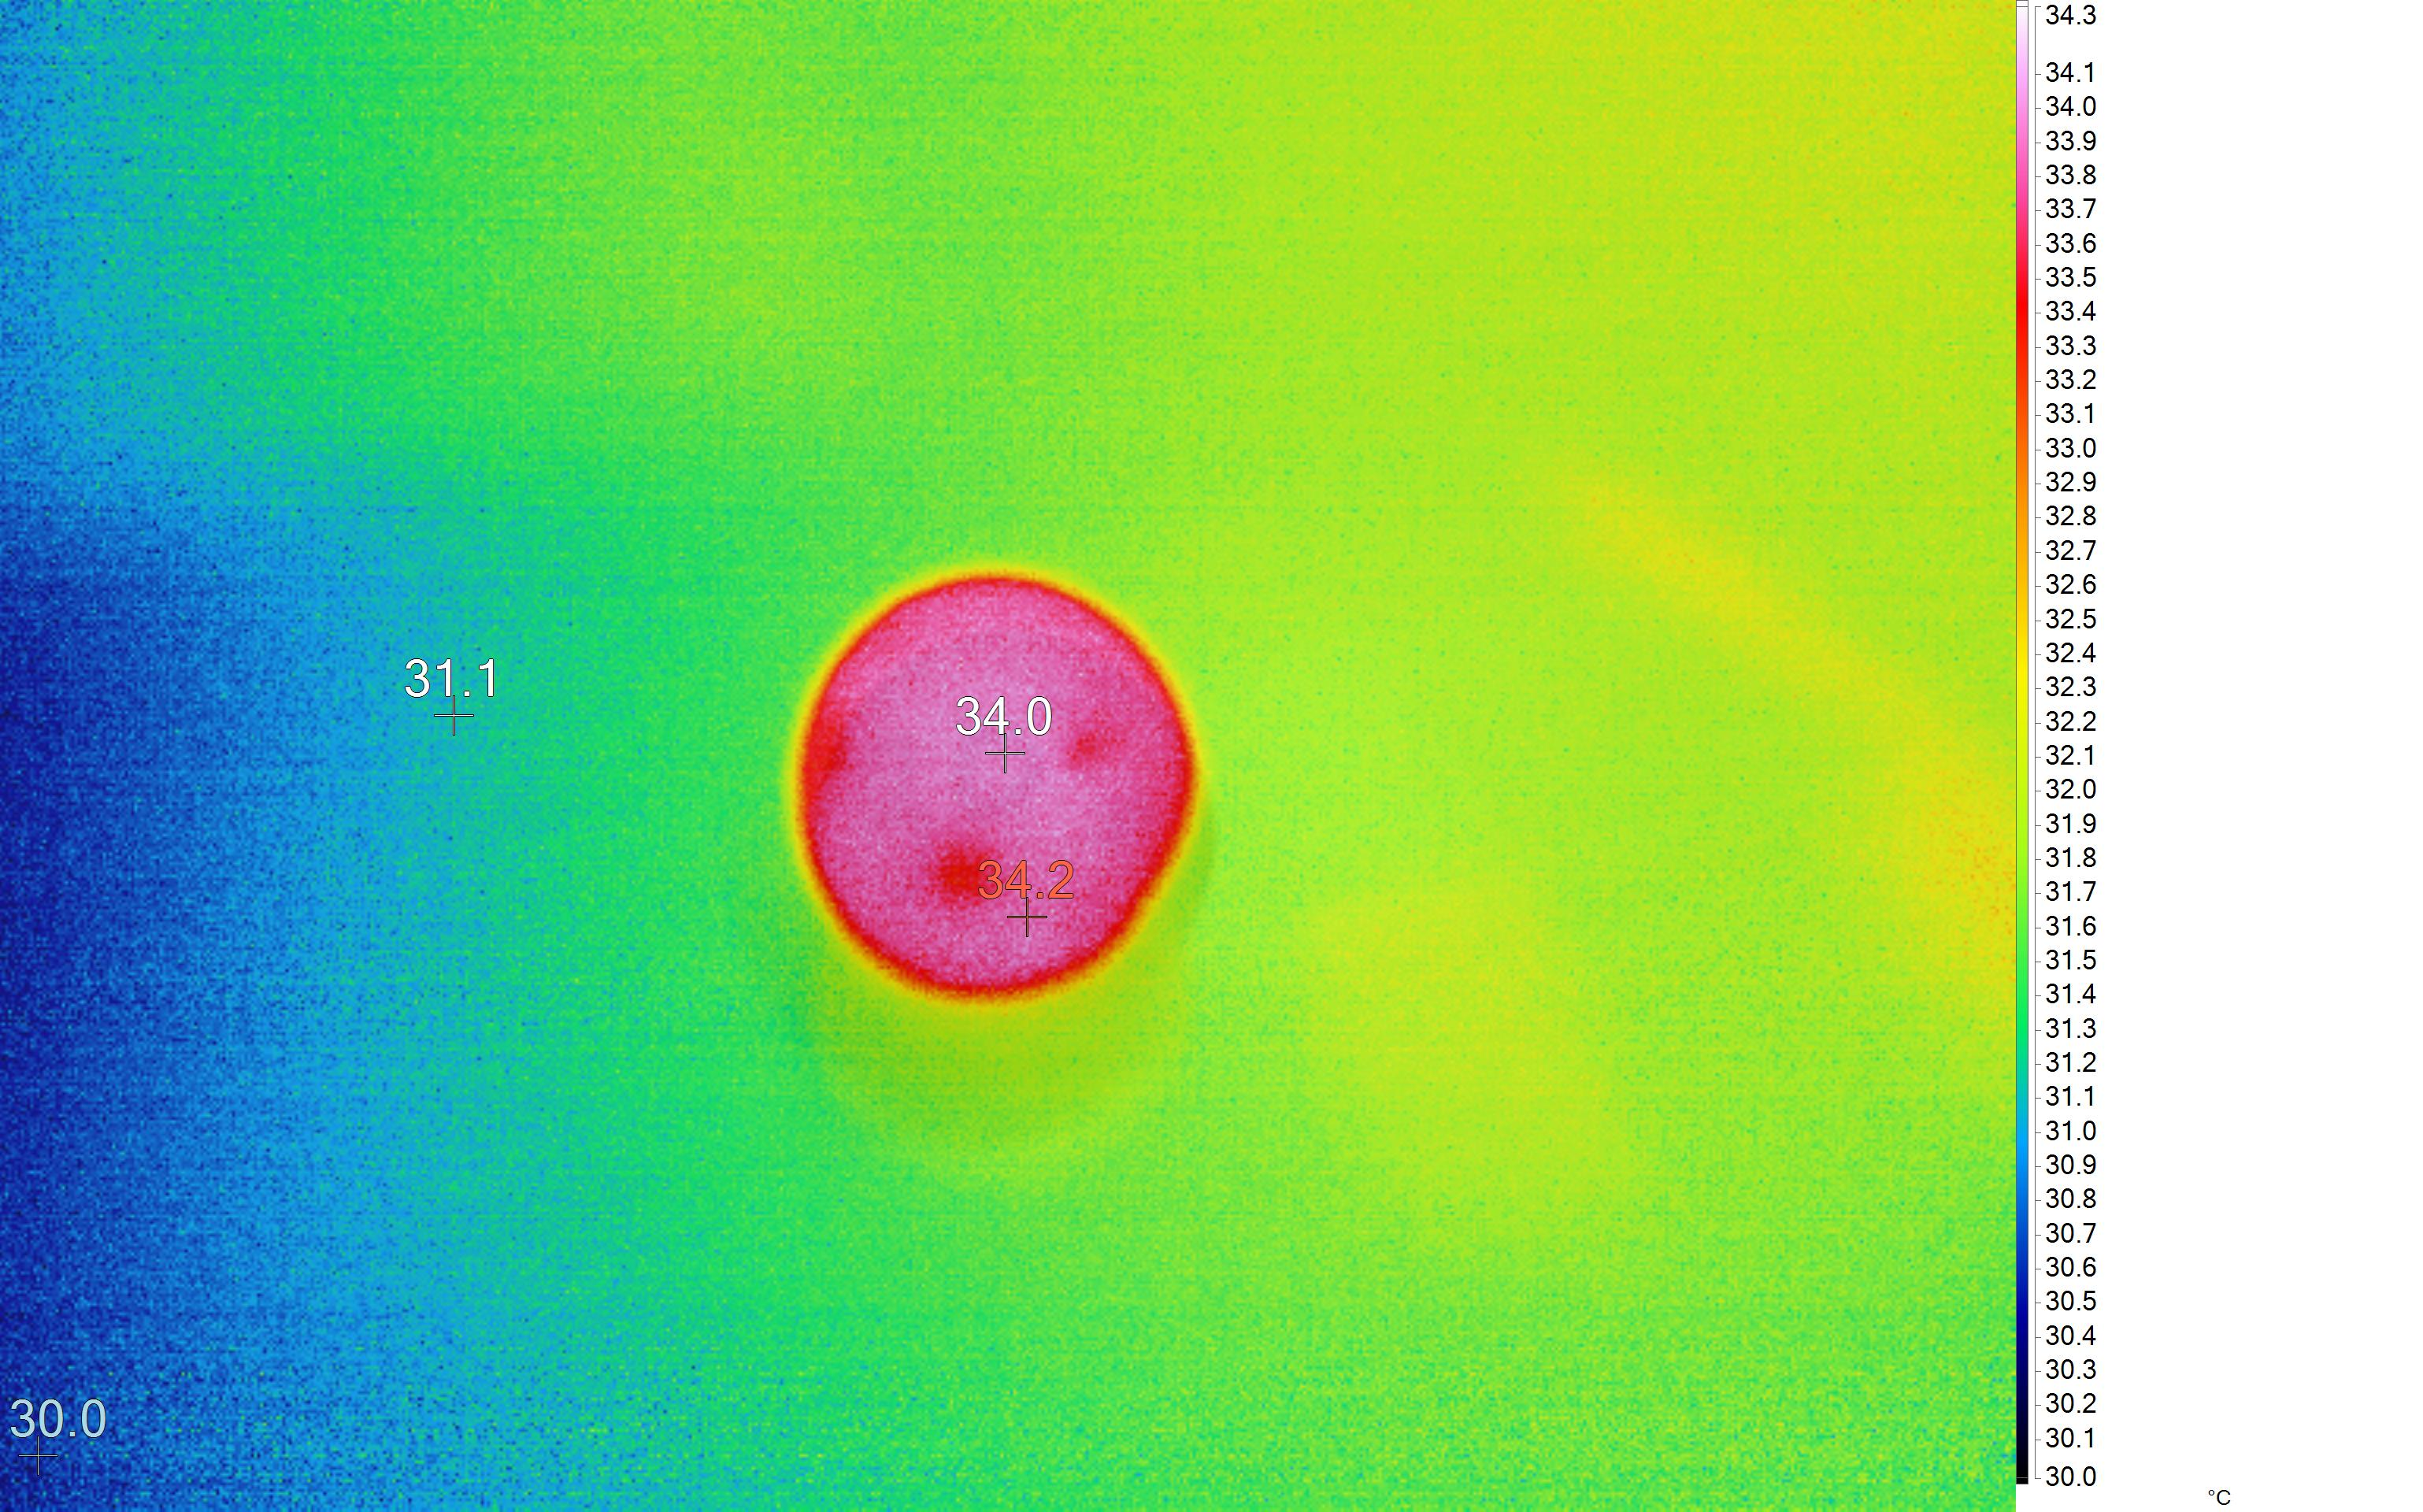

Image Path: dataset\2\Rotten\IR_00338.jpg, Class Label: Rotten, Day: 2


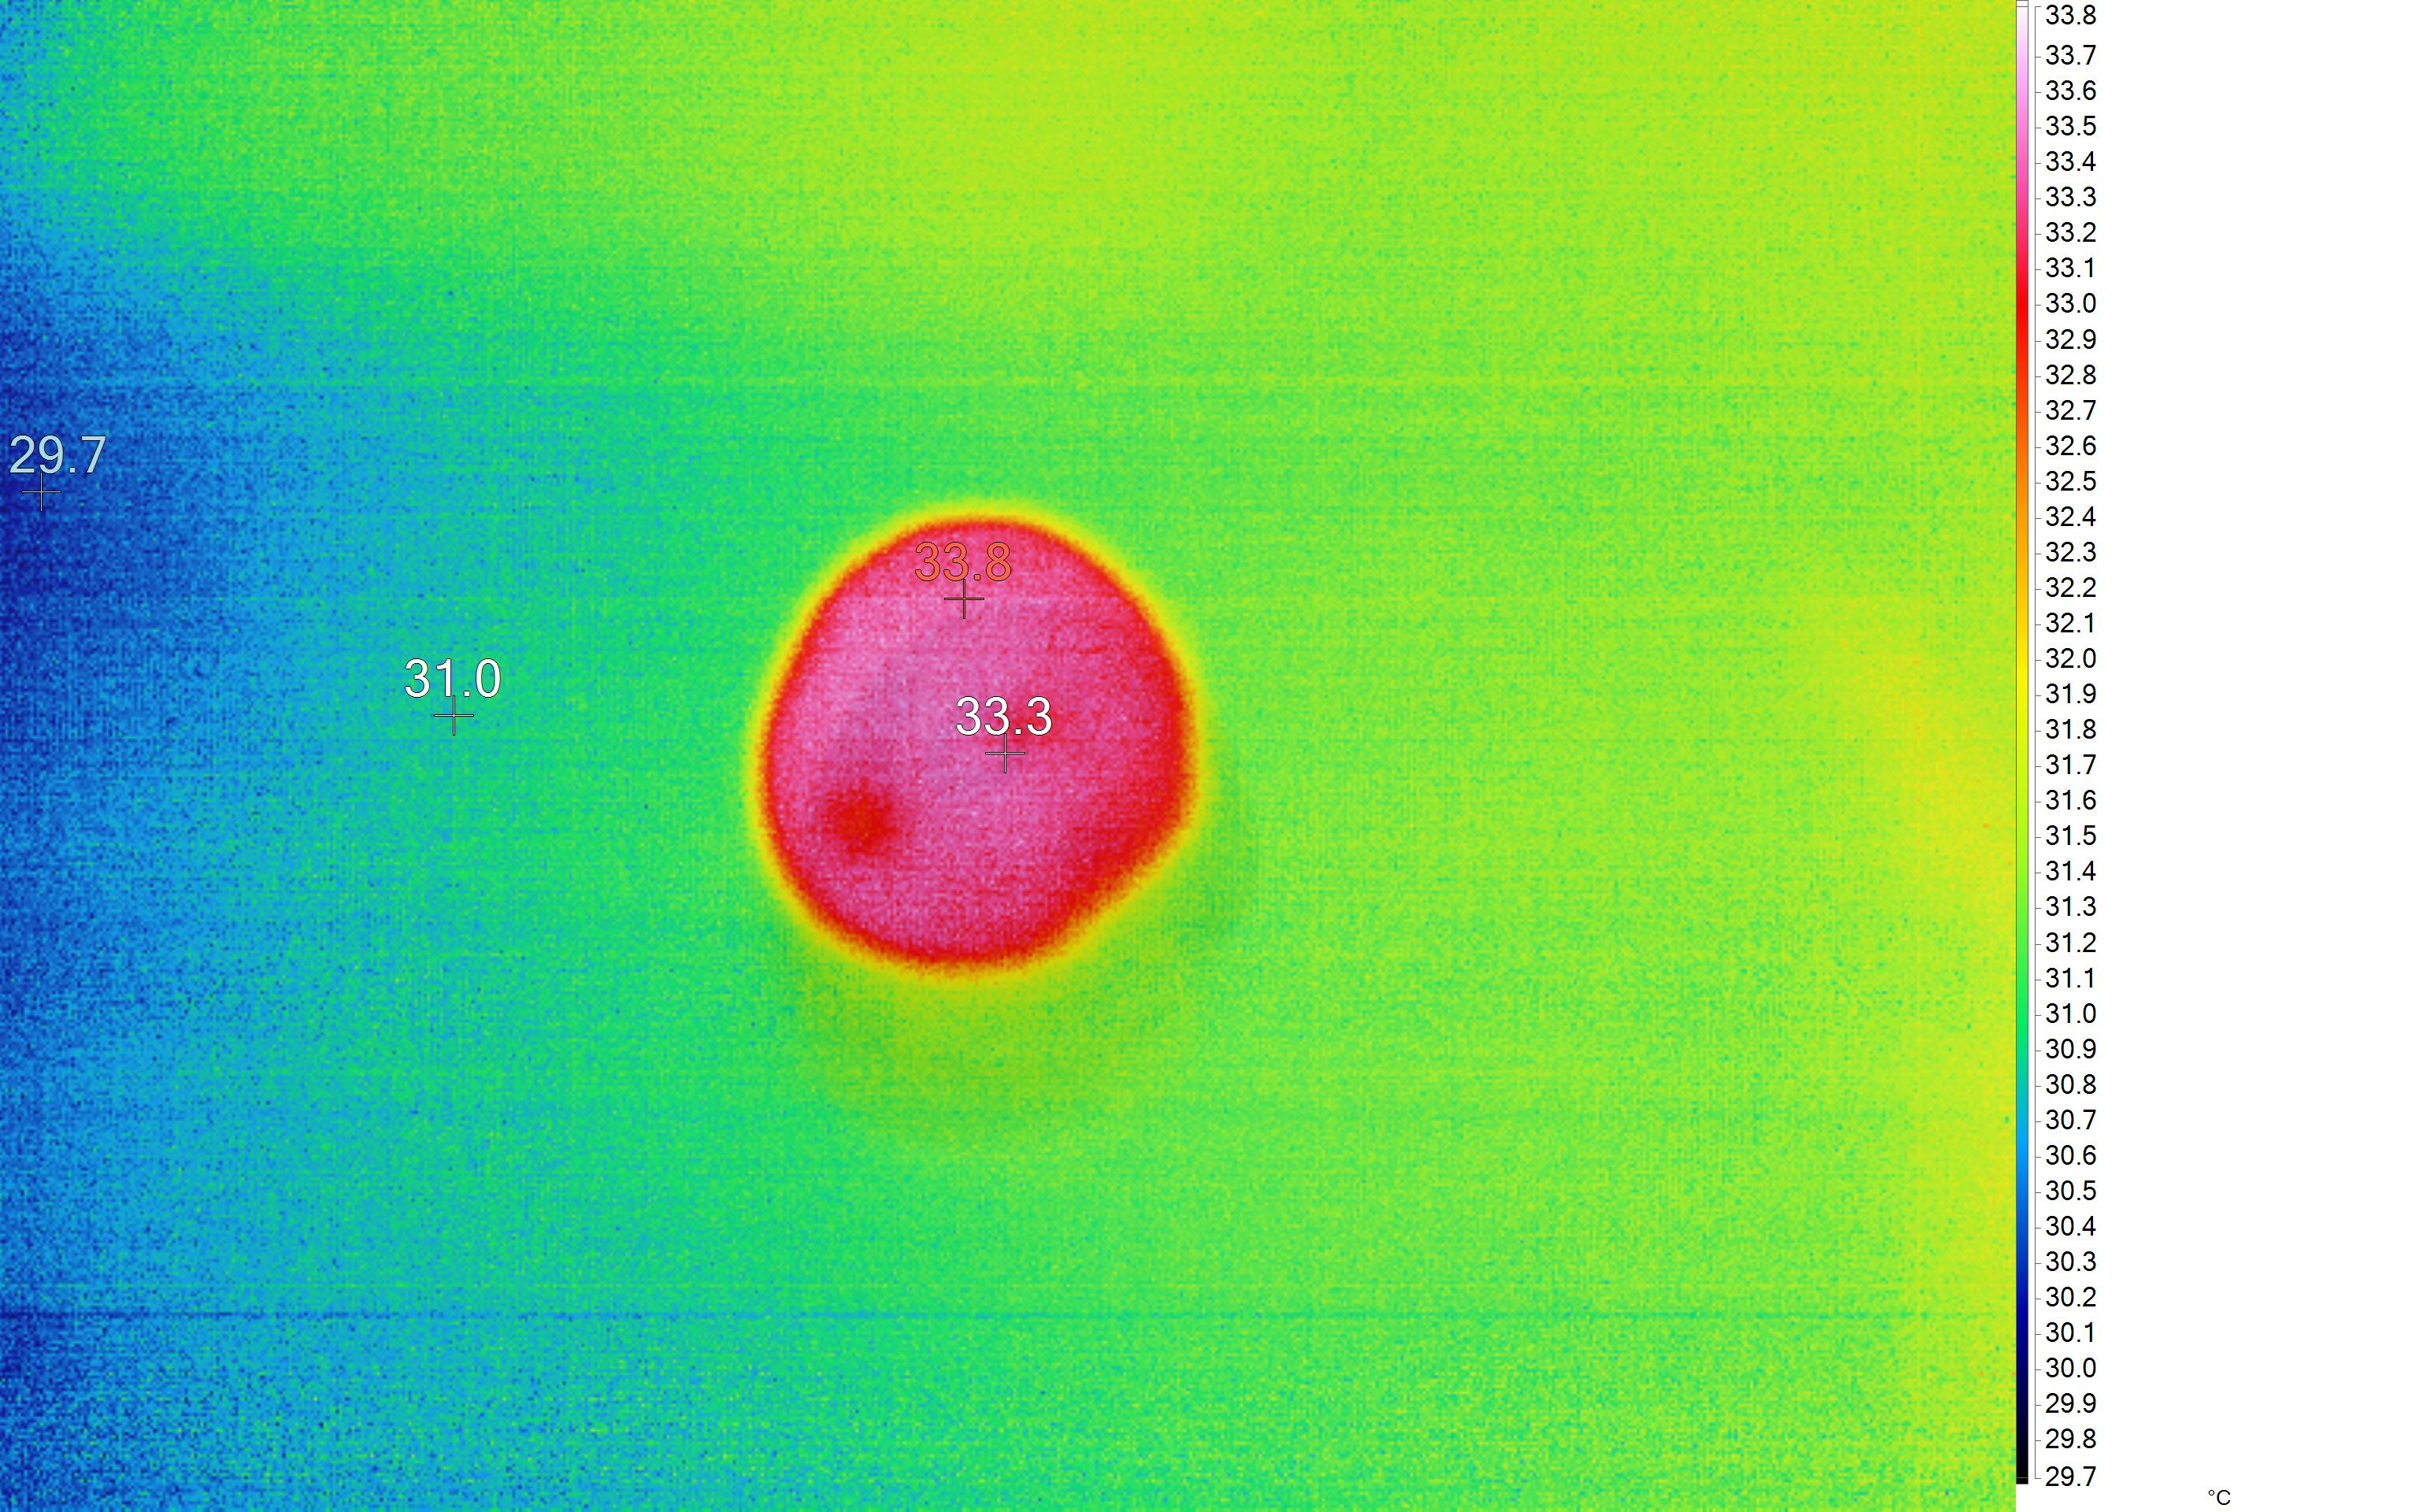

Image Path: dataset\2\Rotten\IR_00339.jpg, Class Label: Rotten, Day: 2


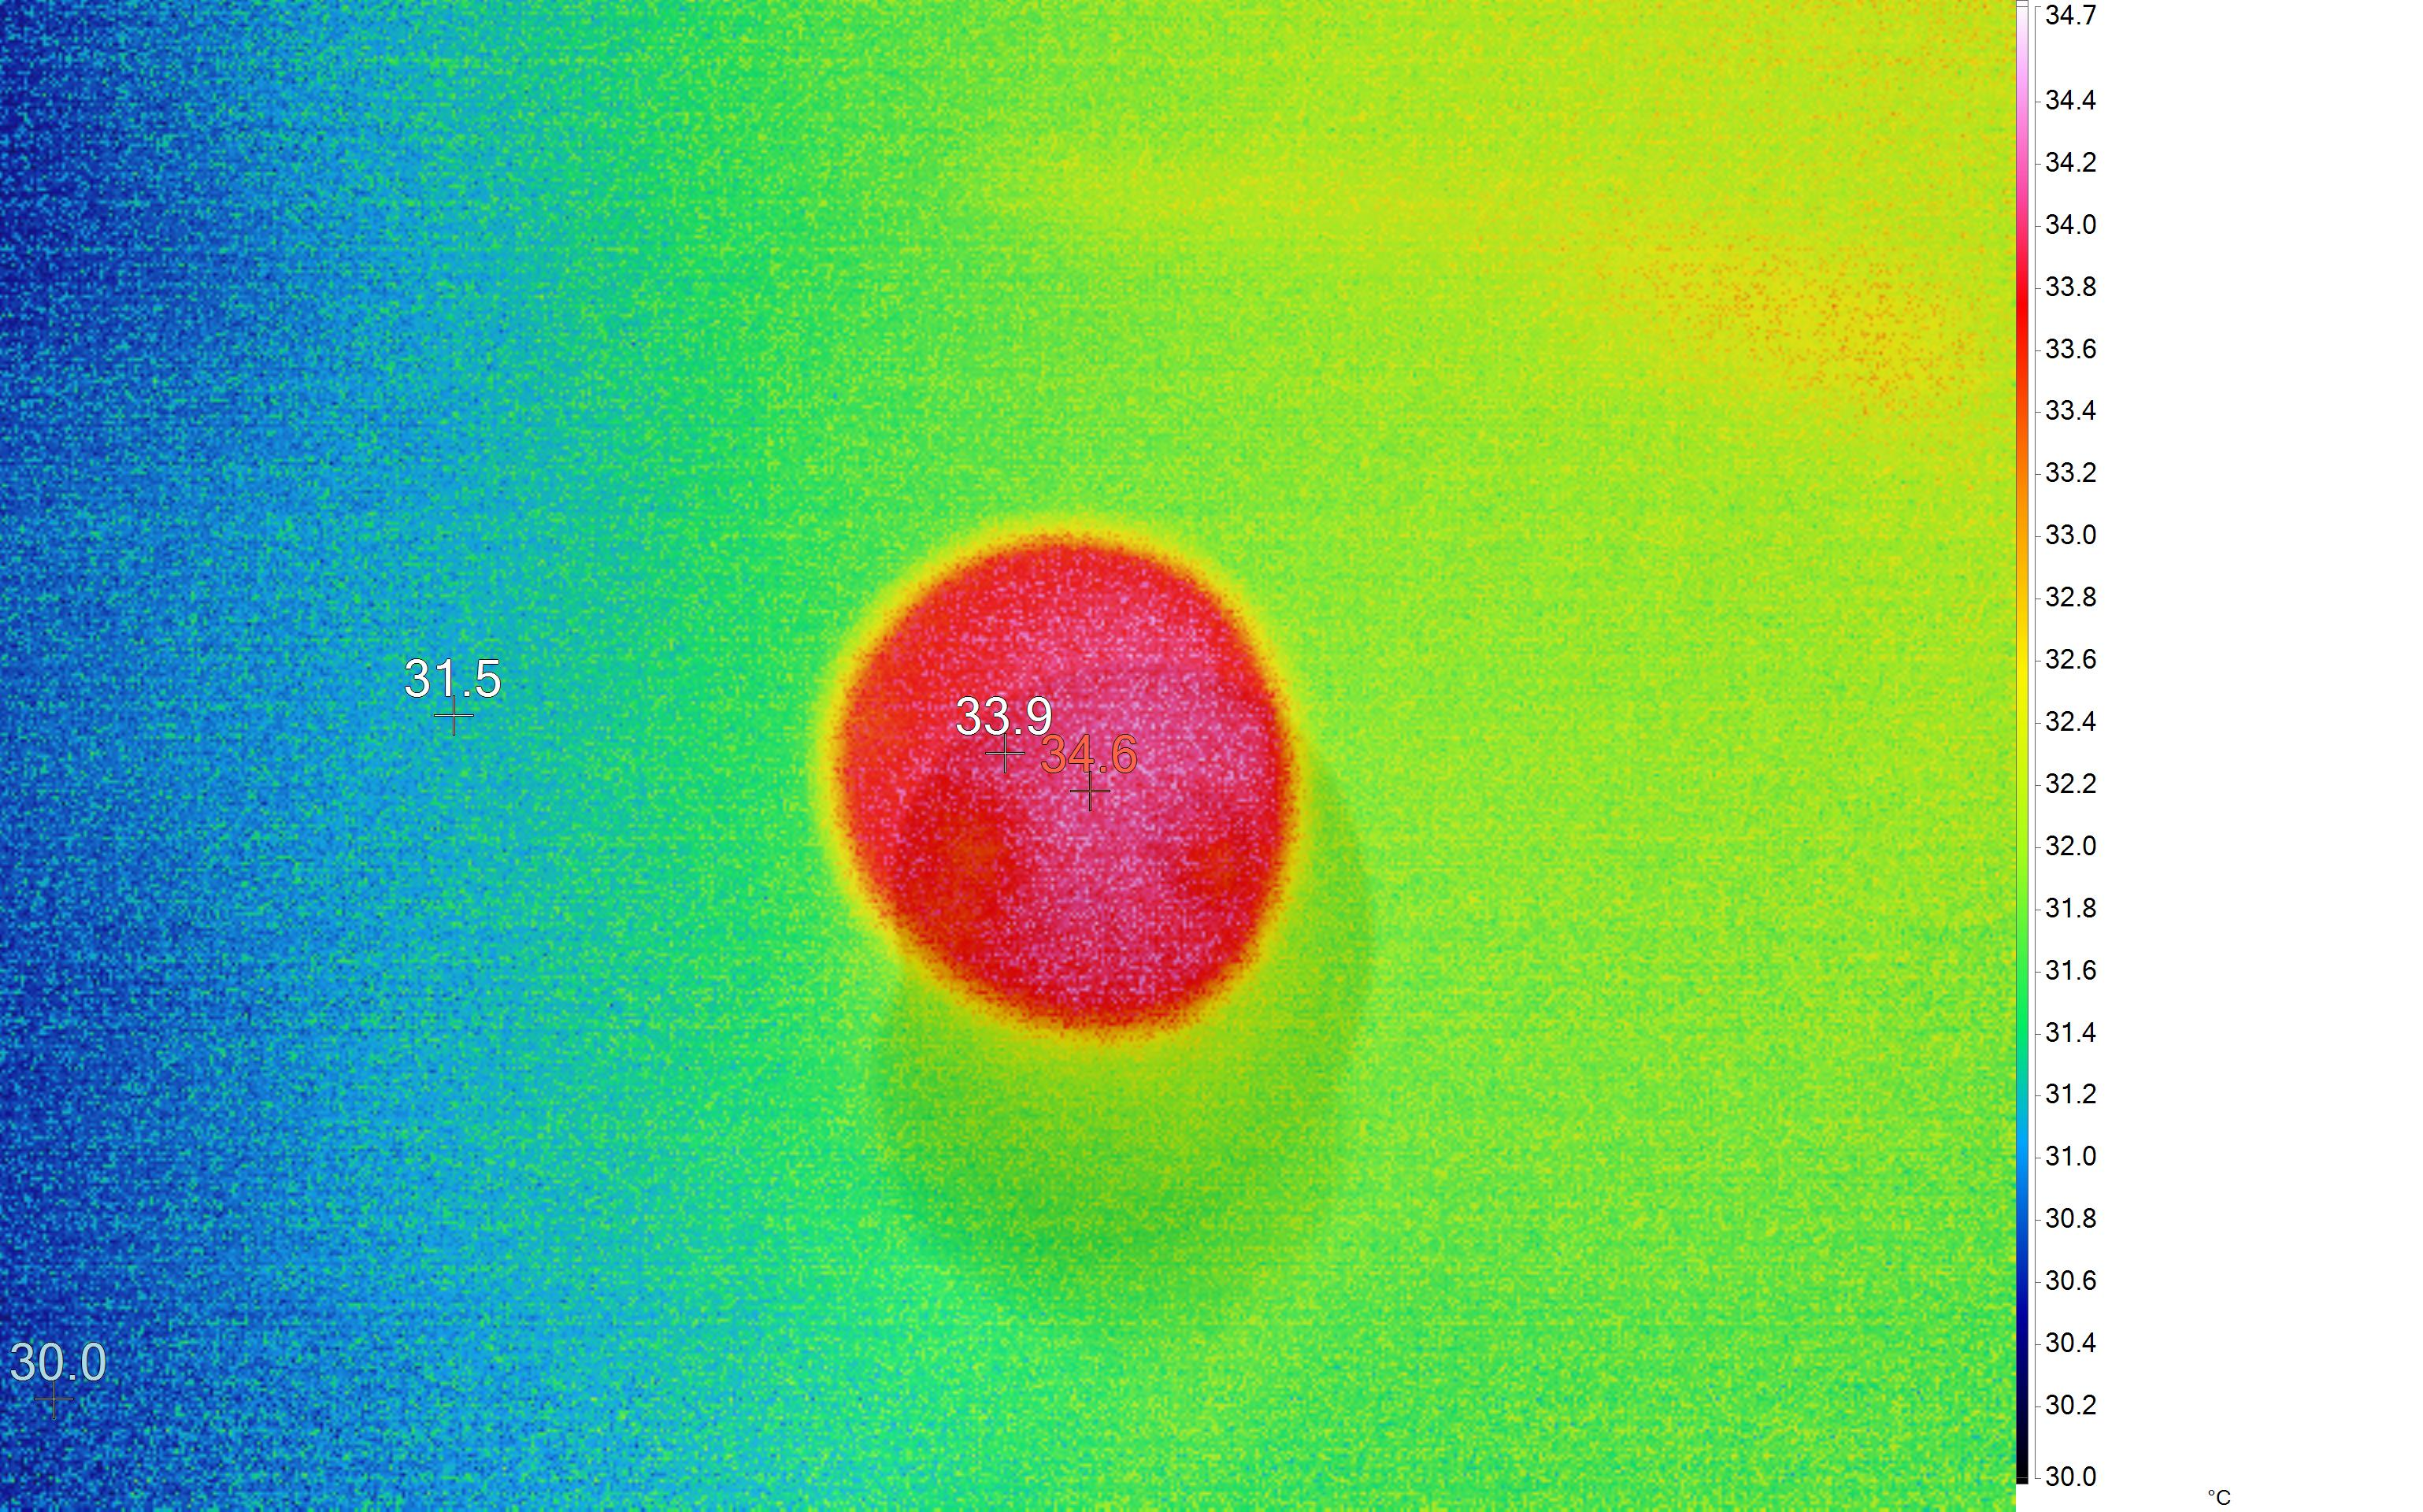

In [4]:


first_5_paths = train_generator.image_paths[:4]
first_5_labels = train_generator.class_labels[:4]
first_5_days = train_generator.days[:4]

print("First 5 Entries:")
for i in range(4):
    print(f"Image Path: {first_5_paths[i]}, Class Label: {'Not Rotten' if first_5_labels[i] == 0 else 'Rotten'}, Day: {first_5_days[i]}")
    display(Image(filename=first_5_paths[i], width=100, height=100))  

In [5]:
train_class_distribution = train_generator.analyze_class_distribution()
print("Training Class Distribution:", train_class_distribution)

train_days_distribution = train_generator.analyze_days_distribution()
print("Training Days Distribution (showing a subset for brevity):")
for day, count in list(train_days_distribution.items())[:5]: 
    print(f"Day {day}: {count} samples")

validation_class_distribution = validation_generator.analyze_class_distribution()
print("\nValidation Class Distribution:", validation_class_distribution)

validation_days_distribution = validation_generator.analyze_days_distribution()
print("Validation Days Distribution (showing a subset for brevity):")
for day, count in list(validation_days_distribution.items())[:5]: 
    print(f"Day {day}: {count} samples")


Training Class Distribution: {'Not Rotten': 814, 'Rotten': 1599}
Training Days Distribution (showing a subset for brevity):
Day 2: 162 samples
Day 3: 269 samples
Day 4: 513 samples
Day 5: 1469 samples

Validation Class Distribution: {'Not Rotten': 814, 'Rotten': 1599}
Validation Days Distribution (showing a subset for brevity):
Day 2: 162 samples
Day 3: 269 samples
Day 4: 513 samples
Day 5: 1469 samples


In [6]:
def build_multi_output_model(input_shape=(224, 224, 3), num_classes=1):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    class_output = Dense(num_classes, activation='sigmoid', name='class_output')(x)

    regression_output = Dense(1, activation="relu",name='regression_output')(x)

    model = Model(inputs=base_model.input, outputs=[class_output, regression_output])

    return model


In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import Input

def build_multi_output_model(input_shape=(224, 224, 3), num_classes=1, num_days=10):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Adding more custom dense layers for increased complexity
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Class output (binary classification, could be adjusted for more classes)
    class_output = Dense(num_classes, activation='sigmoid', name='class_output')(x)

    # Regression output (single continuous output)
    regression_output = Dense(1, activation="relu", name='regression_output')(x)

    # Adding a categorical output for 'days'
    days_output = Dense(num_days, activation='softmax', name='days_output')(x)

    # Creating the model
    model = Model(inputs=base_model.input, outputs=[class_output, regression_output, days_output])

    return model

# Example of model creation
model = build_multi_output_model(num_classes=2, num_days=5)  # Adjust num_classes and num_days based on your data
model.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [8]:
model = build_multi_output_model()

model.compile(optimizer='adam',
              loss={'class_output': 'binary_crossentropy', 'regression_output': 'mean_squared_error'},
              metrics={'class_output': 'accuracy', 'regression_output': 'mae'})


In [9]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [10]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)  
)


Error loading image dataset\2\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000012FCDCAF100>
Epoch 1/10


75/75 [==============================] - ETA: 0s - loss: 2.1940 - class_output_loss: 0.9798 - regression_output_loss: 1.2141 - class_output_accuracy: 0.5046 - regression_output_mae: 0.8103Error loading image dataset\2\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000012F87843060>
Error loading image dataset\2\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000012F86792E80>
Error loading image dataset\2\Not Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000012F8CBAC680>
Error loading image dataset\3\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000012F86790EA0>
Error loading image dataset\3\Not Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000012F8CBA9D50>
75/75 [==============================] - 111s 1s/step - loss: 2.1940 - class_output

In [11]:
results = model.evaluate(validation_generator, steps=len(validation_generator))
print(f"Test Loss, Test Accuracy (Class Output), Test Mean Absolute Error (Regression Output): {results}")


Error loading image dataset\2\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000012F8CE4E890>
Error loading image dataset\2\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000012F8994EC50>
75/75 [==============================] - 57s 757ms/step - loss: 0.9915 - class_output_loss: 0.5335 - regression_output_loss: 0.4580 - class_output_accuracy: 0.7983 - regression_output_mae: 0.5220
Test Loss, Test Accuracy (Class Output), Test Mean Absolute Error (Regression Output): [0.9914910793304443, 0.5334730744361877, 0.45801788568496704, 0.7983333468437195, 0.5220475792884827]


In [12]:
predictions = model.predict(validation_generator, steps=len(validation_generator))
class_predictions = predictions[0]
shelf_life_predictions = predictions[1]


Error loading image dataset\2\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000012F86503150>
Error loading image dataset\2\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000012F8CE5DF80>
75/75 [==============================] - 54s 700ms/step


Error loading image dataset\2\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000012F95B660C0>
Error loading image dataset\2\Not Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000012F95B660C0>
Error loading image dataset\3\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000012FC695C630>
Error loading image dataset\3\Not Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000012F95C28900>


C:\Users\0871\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\0871\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\0871\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

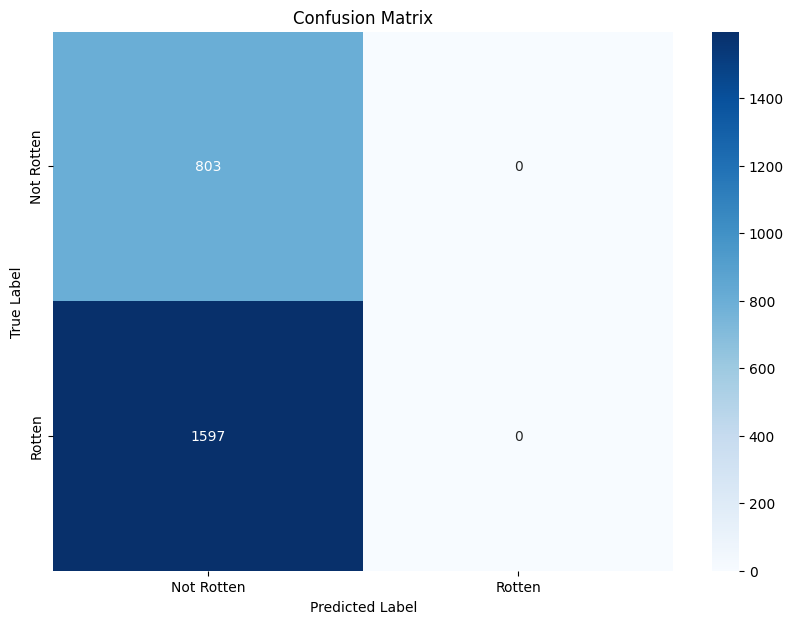


Classification Report:
              precision    recall  f1-score   support

  Not Rotten       0.33      1.00      0.50       803
      Rotten       0.00      0.00      0.00      1597

    accuracy                           0.33      2400
   macro avg       0.17      0.50      0.25      2400
weighted avg       0.11      0.33      0.17      2400



In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Your generator and model code here (assuming these variables are already defined and generated)
def get_true_labels(generator):
    labels = []
    for i in range(len(generator)):
        _, label_batch = generator[i]
        labels.extend(label_batch)
    return labels

# Assuming 'class_predictions' is the output from the model's predict method
true_labels = get_true_labels(validation_generator)
predicted_labels = np.argmax(class_predictions, axis=1)  # assuming class_predictions are from a softmax output

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Classification Report
class_report = classification_report(true_labels, predicted_labels, target_names=['Not Rotten', 'Rotten'])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Rotten', 'Rotten'], yticklabels=['Not Rotten', 'Rotten'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:")
print(class_report)


In [39]:
model.save("mobilenet.h5")

C:\Users\0871\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input


In [48]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import Input

def build_resnet50_multi_output_model(input_shape=(224, 224, 3), num_classes=1, num_days=10):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Adding more custom dense layers for increased complexity
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Class output (binary classification, could be adjusted for more classes)
    class_output = Dense(num_classes, activation='sigmoid', name='class_output')(x)

    # Regression output (single continuous output)
    regression_output = Dense(1, activation="relu", name='regression_output')(x)

    # Adding a categorical output for 'days'
    days_output = Dense(num_days, activation='softmax', name='days_output')(x)

    # Creating the model
    model = Model(inputs=base_model.input, outputs=[class_output, regression_output, days_output])

    return model

# Example of model creation
model = build_resnet50_multi_output_model(num_classes=2, num_days=5)  # Adjust num_classes and num_days based on your data
model.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_8[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [50]:

model = build_resnet50_multi_output_model()  

model.compile(optimizer='adam',
              loss={'class_output': 'binary_crossentropy', 'regression_output': 'mean_squared_error'},
              metrics={'class_output': 'accuracy', 'regression_output': 'mae'})

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)  
)



Error loading image dataset\2\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x00000130082F89F0>
Epoch 1/10
Error loading image dataset\2\Not Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000013008831DA0>
75/75 [==============================] - ETA: 0s - loss: 1.9667 - class_output_loss: 0.9427 - regression_output_loss: 1.0240 - class_output_accuracy: 0.5204 - regression_output_mae: 0.7656Error loading image dataset\2\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000013008C94900>
Error loading image dataset\2\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000013008E50E00>
Error loading image dataset\2\Not Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000013008C943B0>
Error loading image dataset\3\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000013008C943B0>
Error loading image dataset\3\Not Rotten\Thumbs.db: cannot identify image file <_io.B

In [51]:
predictions = model.predict(validation_generator, steps=len(validation_generator))
class_predictions = predictions[0]
shelf_life_predictions = predictions[1]


Error loading image dataset\2\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000012F95AF3C90>
Error loading image dataset\2\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x000001300B607F10>
75/75 [==============================] - 203s 3s/step


Error loading image dataset\2\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000013008E7B1F0>
Error loading image dataset\2\Not Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000013008E7B1F0>
Error loading image dataset\3\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000013008E7B1F0>
Error loading image dataset\3\Not Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000013008E7B1F0>


C:\Users\0871\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\0871\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\0871\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

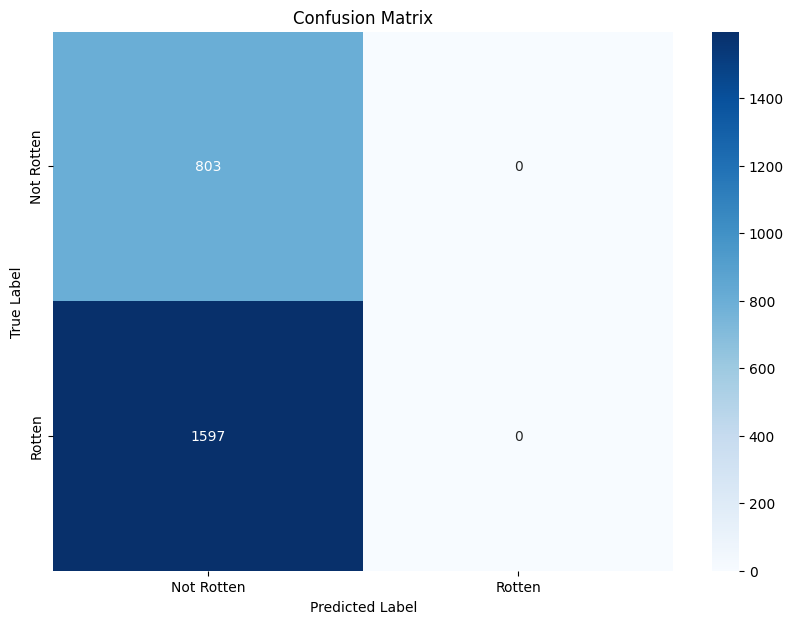


Classification Report:
              precision    recall  f1-score   support

  Not Rotten       0.33      1.00      0.50       803
      Rotten       0.00      0.00      0.00      1597

    accuracy                           0.33      2400
   macro avg       0.17      0.50      0.25      2400
weighted avg       0.11      0.33      0.17      2400



In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Your generator and model code here (assuming these variables are already defined and generated)
def get_true_labels(generator):
    labels = []
    for i in range(len(generator)):
        _, label_batch = generator[i]
        labels.extend(label_batch)
    return labels

# Assuming 'class_predictions' is the output from the model's predict method
true_labels = get_true_labels(validation_generator)
predicted_labels = np.argmax(class_predictions, axis=1)  # assuming class_predictions are from a softmax output

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Classification Report
class_report = classification_report(true_labels, predicted_labels, target_names=['Not Rotten', 'Rotten'])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Rotten', 'Rotten'], yticklabels=['Not Rotten', 'Rotten'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:")
print(class_report)


In [53]:
model.save("resnet.h5")

C:\Users\0871\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [54]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [55]:

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import Input

def build_vgg16_multi_output_model(input_shape=(224, 224, 3), num_classes=1, num_days=10):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Adding more custom dense layers for increased complexity
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Class output (binary classification, could be adjusted for more classes)
    class_output = Dense(num_classes, activation='sigmoid', name='class_output')(x)

    # Regression output (single continuous output)
    regression_output = Dense(1, activation="relu", name='regression_output')(x)

    # Adding a categorical output for 'days'
    days_output = Dense(num_days, activation='softmax', name='days_output')(x)

    # Creating the model
    model = Model(inputs=base_model.input, outputs=[class_output, regression_output, days_output])

    return model

# Example of model creation
model = build_vgg16_multi_output_model(num_classes=2, num_days=5)  # Adjust num_classes and num_days based on your data
model.summary()


Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_11[0][0]']            
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                           

In [56]:

model = build_vgg16_multi_output_model()  

model.compile(optimizer='adam',
              loss={'class_output': 'binary_crossentropy', 'regression_output': 'mean_squared_error'},
              metrics={'class_output': 'accuracy', 'regression_output': 'mae'})

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator), 
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator) 
)



Error loading image dataset\2\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000012F94261C10>
Epoch 1/10
65/75 [=========================>....] - ETA: 36s - loss: 2.0300 - class_output_loss: 0.9461 - regression_output_loss: 1.0839 - class_output_accuracy: 0.4986 - regression_output_mae: 0.7821Error loading image dataset\2\Not Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000012F8CAE6A20>
Error loading image dataset\3\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000012F8CAE6A20>
75/75 [==============================] - ETA: 0s - loss: 1.9772 - class_output_loss: 0.9335 - regression_output_loss: 1.0437 - class_output_accuracy: 0.5021 - regression_output_mae: 0.7657Error loading image dataset\2\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000012F8CB14B30>
Error loading image dataset\2\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000012F8CE959E0>
Error loading imag

In [57]:
predictions = model.predict(validation_generator, steps=len(validation_generator))
class_predictions = predictions[0]
shelf_life_predictions = predictions[1]


Error loading image dataset\2\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x000001300B6588B0>
Error loading image dataset\2\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000012F95B65BC0>
75/75 [==============================] - 276s 4s/step


Error loading image dataset\2\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000013006ED4CC0>
Error loading image dataset\2\Not Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000013006ED4CC0>
Error loading image dataset\3\Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000013006ED4CC0>
Error loading image dataset\3\Not Rotten\Thumbs.db: cannot identify image file <_io.BytesIO object at 0x0000012F95ABC7C0>


C:\Users\0871\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\0871\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\0871\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

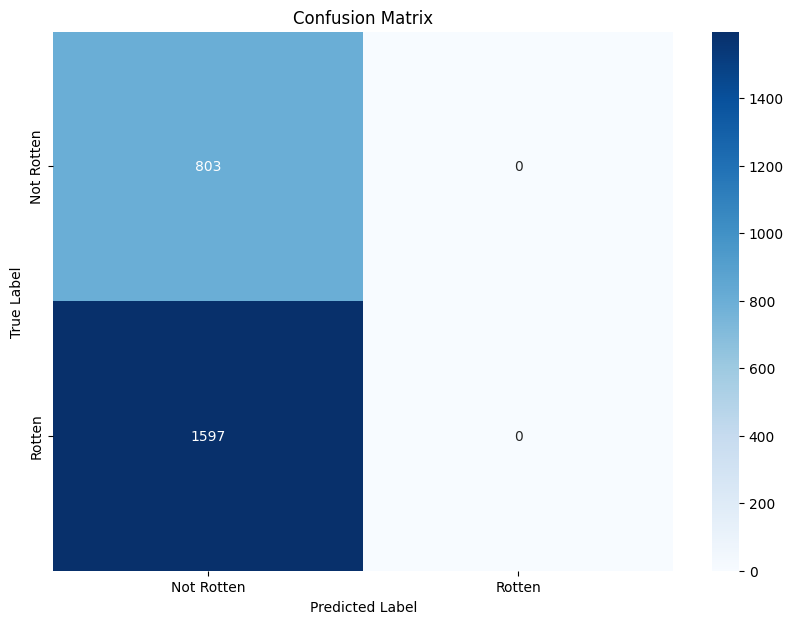


Classification Report:
              precision    recall  f1-score   support

  Not Rotten       0.33      1.00      0.50       803
      Rotten       0.00      0.00      0.00      1597

    accuracy                           0.33      2400
   macro avg       0.17      0.50      0.25      2400
weighted avg       0.11      0.33      0.17      2400



In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Your generator and model code here (assuming these variables are already defined and generated)
def get_true_labels(generator):
    labels = []
    for i in range(len(generator)):
        _, label_batch = generator[i]
        labels.extend(label_batch)
    return labels

# Assuming 'class_predictions' is the output from the model's predict method
true_labels = get_true_labels(validation_generator)
predicted_labels = np.argmax(class_predictions, axis=1)  # assuming class_predictions are from a softmax output

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Classification Report
class_report = classification_report(true_labels, predicted_labels, target_names=['Not Rotten', 'Rotten'])

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Rotten', 'Rotten'], yticklabels=['Not Rotten', 'Rotten'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nClassification Report:")
print(class_report)


In [59]:
model.save("vgg16.h5")

C:\Users\0871\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
